In [ ]:
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Masking, TimeDistributed, Bidirectional  # Import Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping # Import EarlyStopping


In [ ]:
# 1. Load the JSON Data
with open("/content/finger_sequences.json", "r") as file:
    data = json.load(file)

# 2. Prepare Data & Labels
labels = []
sequences = []

for label, instances in data.items():
    for sequence in instances:
        finger_ids = [int(pair[0]) for pair in sequence]  # Convert finger ID to int
        durations = [pair[1] for pair in sequence]  # Extract duration times

        # Append sequence and corresponding label
        sequences.append(list(zip(finger_ids, durations)))
        labels.append(label)

In [ ]:
# 3. Convert Labels to Numeric
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)  # Convert labels to integers

#Padding

In [ ]:
durations = [dur for seq in sequences for _, dur in seq]  # Extract all durations
mean_duration = np.mean(durations)

In [ ]:
def custom_pad_sequences(sequences, maxlen, padding='post', dtype='float32'):
  """Pads sequences with custom values based on label.

  Args:
    sequences: The list of sequences to pad.
    maxlen: The desired length for all sequences.
    padding: 'pre' or 'post' (default 'post').
    dtype: The data type of the padded sequences.

  Returns:
    A NumPy array of padded sequences.
  """
  padded_sequences = []
  for i, seq in enumerate(sequences):  # Use enumerate to get index i
    # Determine padding element based on corresponding label
    label = labels[i]  # Get label for the sequence
    if label == 'CallHarisVai':
      padding_element = ("2", mean_duration)  # Using finger_map dictionary
    elif label == 'Noise':
      padding_element = ("1", mean_duration)  # Using finger_map dictionary
    elif label == 'LikeMe':
      padding_element = ("3", mean_duration)  # Using finger_map dictionary
    elif label == 'ComeCLose':
      padding_element = ("8", mean_duration)  # Using finger_map dictionary
    else:
      padding_element = (int(-1), mean_duration)  # Default padding element

    # Pad the sequence to the desired length
    if len(seq) < maxlen:
      padding_elements = [padding_element] * (maxlen - len(seq))
      if padding == 'pre':
        padded_seq = padding_elements + seq
      else:  # padding == 'post'
        padded_seq = seq + padding_elements
    else:
      padded_seq = seq[:maxlen]  # Truncate if longer than maxlen

    padded_sequences.append(padded_seq)
  return np.array(padded_sequences, dtype=dtype)

In [ ]:
# 4. Pad Sequences for Uniform Length (Modified)
max_seq_length = max(len(seq) for seq in sequences)
padded_sequences = custom_pad_sequences(sequences, maxlen=max_seq_length, padding='post', dtype='float32')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8750 - loss: 0.5874
Test Accuracy: 0.8750


# output 1 sequence

In [ ]:
# 5. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, encoded_labels, test_size=0.2, random_state=42)

model = Sequential([
    Masking(mask_value=0.0, input_shape=(max_seq_length, 2)),  # Corrected input shape to (max_seq_length, 2)
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)), #Added this LSTM layer without return_sequences=True.
    #This will return the output from the last timestep in the Bidirectional LSTM.
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(len(set(labels)), activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 8. Train with Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=100, batch_size=16,
          validation_data=(X_test, y_test),
          callbacks=[early_stop])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100


ValueError: Argument `output` must have rank (ndim) `target.ndim - 1`. Received: target.shape=(16,), output.shape=(16, 33, 4)

# label sequence output

In [ ]:
# 5. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, encoded_labels, test_size=0.2, random_state=42)

# Duplicate labels for each timestep in the sequence
y_train_repeated = np.repeat(y_train[:, np.newaxis], max_seq_length, axis=1)
y_test_repeated = np.repeat(y_test[:, np.newaxis], max_seq_length, axis=1)


model = Sequential([
    Masking(mask_value=0.0, input_shape=(max_seq_length, 2)),  # Corrected input shape to (max_seq_length, 2)
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32, return_sequences=True)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    TimeDistributed(Dense(len(set(labels)), activation='softmax')) # Wrap the final Dense layer with TimeDistributed
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 8. Train with Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train_repeated, epochs=100, batch_size=16, # Use the repeated labels for training
          validation_data=(X_test, y_test_repeated), # Use the repeated labels for validation
          callbacks=[early_stop])


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 751ms/step - accuracy: 0.4316 - loss: 1.3737 - val_accuracy: 0.4413 - val_loss: 1.2762
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.5225 - loss: 1.2074 - val_accuracy: 0.4962 - val_loss: 1.1187
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.5184 - loss: 1.1082 - val_accuracy: 0.5114 - val_loss: 1.0299
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - accuracy: 0.5513 - loss: 1.0023 - val_accuracy: 0.5227 - val_loss: 0.9749
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step - accuracy: 0.5631 - loss: 0.9225 - val_accuracy: 0.5246 - val_loss: 0.9257
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 377ms/step - accuracy: 0.5686 - loss: 0.8706 - val_accuracy: 0.5284 - val_loss: 0.8915
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step - accuracy: 0.6265 - loss: 0.7944 - val_accuracy: 0.5795 - val_loss: 0.8401
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.6593 - loss: 0.7715 - val_accuracy: 0.6477 - 

In [ ]:
# 5. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, encoded_labels, test_size=0.2, random_state=42)

# Duplicate labels for each timestep in the sequence
y_train_repeated = np.repeat(y_train[:, np.newaxis], max_seq_length, axis=1)
y_test_repeated = np.repeat(y_test[:, np.newaxis], max_seq_length, axis=1)


model = Sequential([
    Masking(mask_value=0.0, input_shape=(max_seq_length, 2)),  # Corrected input shape to (max_seq_length, 2)
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32, return_sequences=True)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    TimeDistributed(Dense(2, activation='linear'))  # Output layer for finger ID and duration
])

model.compile(loss='mse', optimizer='adam', metrics=['mae'])

# 8. Train with Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


model.fit(X_train, y_train, epochs=100, batch_size=16,
          validation_data=(X_test, y_test),
          callbacks=[early_stop])


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


ValueError: Dimensions must be equal, but are 16 and 2 for '{{node compile_loss/mse/sub}} = Sub[T=DT_FLOAT](compile_loss/mse/Cast, sequential_11_1/time_distributed_15_1/transpose_2)' with input shapes: [16], [16,33,2].

In [ ]:
# 5. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, encoded_labels, test_size=0.2, random_state=42)

# Reshape y_train and y_test to (num_samples, 1)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Duplicate labels for each timestep in the sequence
y_train_repeated = np.repeat(y_train, max_seq_length, axis=1)
y_test_repeated = np.repeat(y_test, max_seq_length, axis=1)

# Reshape to (num_samples, sequence_length, num_features)
y_train_repeated = y_train_repeated[:, :, np.newaxis]  # Add a new axis for features
y_test_repeated = y_test_repeated[:, :, np.newaxis]  # Add a new axis for features

# Add duration information to y_train_repeated and y_test_repeated
# Assuming your padded_sequences have shape (num_samples, sequence_length, 2)
# where the last dimension contains (finger_id, duration)
# Use X_train and X_test instead of padded_sequences to match the shapes
y_train_repeated = np.concatenate([y_train_repeated, X_train[:, :, 1:]], axis=2)  # Concatenate duration
y_test_repeated = np.concatenate([y_test_repeated, X_test[:, :, 1:]], axis=2)  # Concatenate duration


model = Sequential([
    Masking(mask_value=0.0, input_shape=(max_seq_length, 2)),  # Corrected input shape to (max_seq_length, 2)
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32, return_sequences=True)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    TimeDistributed(Dense(2, activation='linear'))  # Output layer for finger ID and duration
])

model.compile(loss='mse', optimizer='adam', metrics=['mae'])

# 8. Train with Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(X_train, y_train_repeated, epochs=100, batch_size=16,
          validation_data=(X_test, y_test_repeated),
          callbacks=[early_stop])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 896ms/step - loss: 1.5458 - mae: 0.8494 - val_loss: 1.1528 - val_mae: 0.7930
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - loss: 0.9575 - mae: 0.7128 - val_loss: 1.0872 - val_mae: 0.8273
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - loss: 0.8817 - mae: 0.7105 - val_loss: 1.0579 - val_mae: 0.7519
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - loss: 0.8282 - mae: 0.6525 - val_loss: 1.0406 - val_mae: 0.7591
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - loss: 0.8245 - mae: 0.6557 - val_loss: 1.0032 - val_mae: 0.7388
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - loss: 0.8956 - mae: 0.6863 - val_loss: 0.9897 - val_mae: 0.7492
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - loss: 0.8404 - mae: 0.6783 - val_loss: 1.0281 - val_mae: 0.7500
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - loss: 0.7595 - mae: 0.6222 - val_loss: 0.9702 - val_mae: 0.7245
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - loss: 0.75

In [ ]:
# 9. Evaluate Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

OperatorNotAllowedInGraphError: Exception encountered when calling TimeDistributed.call().

[1mUsing a symbolic `tf.Tensor` as a Python `bool` is not allowed. You can attempt the following resolutions to the problem: If you are running in Graph mode, use Eager execution mode or decorate this function with @tf.function. If you are using AutoGraph, you can try decorating this function with @tf.function. If that does not work, then you may be using an unsupported feature or your source code may not be visible to AutoGraph. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/limitations.md#access-to-source-code for more information.[0m

Arguments received by TimeDistributed.call():
  • inputs=tf.Tensor(shape=(None, 33, 64), dtype=float32)
  • training=False
  • mask=tf.Tensor(shape=(None, 33), dtype=bool)

In [ ]:
# 10. Save Model
model.save("lstm_finger_Sq_model.h5")

# This give linear output

In [ ]:
# 5. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, encoded_labels, test_size=0.2, random_state=42)

# Reshape y_train and y_test to (num_samples, 1)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Duplicate labels for each timestep in the sequence
y_train_repeated = np.repeat(y_train, max_seq_length, axis=1)
y_test_repeated = np.repeat(y_test, max_seq_length, axis=1)

# Reshape to (num_samples, sequence_length, num_features)
y_train_repeated = y_train_repeated[:, :, np.newaxis]  # Add a new axis for features
y_test_repeated = y_test_repeated[:, :, np.newaxis]  # Add a new axis for features

# Add duration information to y_train_repeated and y_test_repeated
# Assuming your padded_sequences have shape (num_samples, sequence_length, 2)
# where the last dimension contains (finger_id, duration)
# Use X_train and X_test instead of padded_sequences to match the shapes
y_train_repeated = np.concatenate([y_train_repeated, X_train[:, :, 1:]], axis=2)  # Concatenate duration
y_test_repeated = np.concatenate([y_test_repeated, X_test[:, :, 1:]], axis=2)  # Concatenate duration


model = Sequential([
    Masking(mask_value=0.0, input_shape=(max_seq_length, 2)),  # Corrected input shape to (max_seq_length, 2)
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32, return_sequences=True)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    TimeDistributed(Dense(2, activation='linear'))  # Output layer for finger ID and duration
])

model.compile(loss='mse', optimizer='adam', metrics=['mse'])

# 8. Train with Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(X_train, y_train_repeated, epochs=100, batch_size=16,
          validation_data=(X_test, y_test_repeated),
          callbacks=[early_stop])

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 680ms/step - loss: 1.9941 - mse: 1.9941 - val_loss: 1.2536 - val_mse: 1.2536
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step - loss: 1.0505 - mse: 1.0505 - val_loss: 1.1309 - val_mse: 1.1309
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step - loss: 0.9406 - mse: 0.9406 - val_loss: 1.0770 - val_mse: 1.0770
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - loss: 0.9341 - mse: 0.9341 - val_loss: 1.1047 - val_mse: 1.1047
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - loss: 0.8882 - mse: 0.8882 - val_loss: 1.0687 - val_mse: 1.0687
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - loss: 0.7702 - mse: 0.7702 - val_loss: 1.0241 - val_mse: 1.0241
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step - loss: 0.8532 - mse: 0.8532 - val_loss: 1.0212 - val_mse: 1.0212
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step - loss: 0.8005 - mse: 0.8005 - val_loss: 1.0210 - val_mse: 1.0210
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - loss: 0.8202 - mse: 0.

In [ ]:
# 10. Save Model
model.save("lstm_finger_Sqmse_model.h5")

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError

# Load the model and explicitly define the loss function
model = load_model("lstm_finger_Sqmse_model.h5", custom_objects={'mse': MeanSquaredError()})

# 2. Function to preprocess the input sequence (same as before)
def preprocess_input(sequence):
    """Preprocesses a raw sequence for prediction.

    Args:
        sequence: A list of (finger_id, duration) tuples representing the sequence.

    Returns:
        A padded NumPy array representing the sequence.
    """
    finger_ids = [int(pair[0]) for pair in sequence]
    durations = [pair[1] for pair in sequence]
    input_sequence = list(zip(finger_ids, durations))

    # Pad the sequence to match the model's input shape
    padded_sequence = pad_sequences([input_sequence], maxlen=max_seq_length, padding='post', dtype='float32')
    return padded_sequence

# 3. Example new input sequence
new_sequence = [(1, 0.5), (2, 0.3), (3, 0.2)]

# 4. Preprocess the input
processed_sequence = preprocess_input(new_sequence)

# 5. Get model predictions
predictions = model.predict(processed_sequence)

# 6. Interpret the predictions
# predictions will have shape (1, max_seq_length, 2)
# - predictions[0, i, 0] represents the predicted finger ID for timestep i
# - predictions[0, i, 1] represents the predicted duration for timestep i

# Example: Print predictions for each timestep
for i in range(max_seq_length):
    finger_id = predictions[0, i, 0]
    duration = predictions[0, i, 1]
    print(f"Timestep {i + 1}: Predicted Finger ID: {finger_id:.2f}, Predicted Duration: {duration:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Timestep 1: Predicted Finger ID: 0.61, Predicted Duration: 0.04
Timestep 2: Predicted Finger ID: 0.67, Predicted Duration: 0.03
Timestep 3: Predicted Finger ID: 0.69, Predicted Duration: 0.01
Timestep 4: Predicted Finger ID: 0.20, Predicted Duration: -0.01
Timestep 5: Predicted Finger ID: 0.20, Predicted Duration: -0.01
Timestep 6: Predicted Finger ID: 0.20, Predicted Duration: -0.01
Timestep 7: Predicted Finger ID: 0.20, Predicted Duration: -0.01
Timestep 8: Predicted Finger ID: 0.20, Predicted Duration: -0.01
Timestep 9: Predicted Finger ID: 0.20, Predicted Duration: -0.01
Timestep 10: Predicted Finger ID: 0.20, Predicted Duration: -0.01
Timestep 11: Predicted Finger ID: 0.20, Predicted Duration: -0.01
Timestep 12: Predicted Finger ID: 0.20, Predicted Duration: -0.01
Timestep 13: Predicted Finger ID: 0.20, Predicted Duration: -0.01
Timestep 14: Predicted Finger ID: 0.20, Predicted Duration: -0.01
Timestep 15: Predicted Finger ID: 0.20, Predicted Du

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
import pickle

# 1. Load the saved model
model = load_model("lstm_finger_model.h5")

# 2. Load the label encoder
with open('label_encoder_model.pkl', 'rb') as file:
    label_encoder = pickle.load(file)

# 3. Function to preprocess the input sequence
def preprocess_input(sequence):
  """Preprocesses a raw sequence for prediction.

  Args:
    sequence: A list of (finger_id, duration) tuples representing the sequence.

  Returns:
    A padded NumPy array representing the sequence.
  """
  finger_ids = [int(pair[0]) for pair in sequence]
  durations = [pair[1] for pair in sequence]
  input_sequence = list(zip(finger_ids, durations))

  # Pad the sequence to match the model's input shape
  # Assuming max_seq_length is defined or loaded from somewhere
  padded_sequence = pad_sequences([input_sequence], maxlen=max_seq_length, padding='post', dtype='float32')
  return padded_sequence

# 4. Example new input sequence
new_sequence = [(1, 0.5), (2, 0.3), (3, 0.2)]  # Replace with your actual sequence

# 5. Preprocess the input
processed_sequence = preprocess_input(new_sequence)

# 6. Make prediction
prediction = np.argmax(model.predict(processed_sequence), axis=1)

print(prediction)

# 7. Convert prediction back to label
predicted_label = label_encoder.inverse_transform(prediction)[0]  # Use index 0

# 8. Print the predicted gesture
print(f"Predicted Gesture: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[2]
Predicted Gesture: LikeMe


In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Import pad_sequences

# 1. Load the saved model
model = load_model("lstm_finger_model.h5")

# 2. Load the label encoder
with open('label_encoder_model.pkl', 'rb') as file:
    label_encoder = pickle.load(file)

# 3. Function to preprocess the input sequence
def preprocess_input(sequence):
  """Preprocesses a raw sequence for prediction.

  Args:
    sequence: A list of (finger_id, duration) tuples representing the sequence.

  Returns:
    A padded NumPy array representing the sequence.
  """
  finger_ids = [int(pair[0]) for pair in sequence]
  durations = [pair[1] for pair in sequence]
  input_sequence = list(zip(finger_ids, durations))

  # Pad the sequence to match the model's input shape
  # Assuming max_seq_length is defined or loaded from somewhere
  padded_sequence = pad_sequences([input_sequence], maxlen=max_seq_length, padding='post', dtype='float32')
  return padded_sequence

# 4. List of input sequences
sequences = [
    [(1, 0.5), (2, 0.3), (3, 0.2)],
    [(2, 0.4), (3, 0.6), (1, 0.3)],
    [(3, 0.2), (1, 0.5), (2, 0.4)]
    # Add more sequences as needed
]

# 5. Predict and print for each sequence
for sequence in sequences:
    processed_sequence = preprocess_input(sequence)
    prediction = np.argmax(model.predict(processed_sequence), axis=1)
    print(prediction)
    # predicted_label = label_encoder.inverse_transform(prediction)[0]  # Use index 0
    # print(f"Sequence: {sequence}, Predicted Gesture: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[0 3 3 2]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
[[3 3 3 2]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
[[3 3 3 2]]


# sample

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking, TimeDistributed
# ... (other imports)


# 1. Reshape target data for next-step prediction
y_train_shifted = np.zeros_like(X_train)  # Initialize with zeros
y_test_shifted = np.zeros_like(X_test)

for i in range(len(X_train)):
    y_train_shifted[i, :-5] = X_train[i, 5:]  # Shift target by 5 steps

for i in range(len(X_test)):
    y_test_shifted[i, :-5] = X_test[i, 5:]

# 2. Modify model architecture for sequence prediction
model = Sequential([
    Masking(mask_value=0.0, input_shape=(max_seq_length, 2)),
    LSTM(128, return_sequences=True),
    LSTM(64, return_sequences=True),
    LSTM(32, return_sequences=True),  # Return sequences for all timesteps
    Dropout(0.3),
    Dense(64, activation='relu'),
    TimeDistributed(Dense(2, activation='linear'))  # Predict finger ID and duration
])

# 3. Compile and train the model
model.compile(loss='mse', optimizer='adam', metrics=['mae'])
model.fit(X_train, y_train_shifted, epochs=50, batch_size=16,
          validation_data=(X_test, y_test_shifted), callbacks=[early_stop])



Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - loss: 2.8193 - mae: 0.9732 - val_loss: 1.7813 - val_mae: 0.8518
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 2.1383 - mae: 0.8814 - val_loss: 1.5088 - val_mae: 0.7899
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 2.1504 - mae: 0.8788 - val_loss: 1.4344 - val_mae: 0.7455
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 1.8564 - mae: 0.8156 - val_loss: 1.3060 - val_mae: 0.7429
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 1.9352 - mae: 0.8282 - val_loss: 1.2549 - val_mae: 0.6866
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 1.9016 - mae: 0.8081 - val_loss: 1.1901 - val_mae: 0.6596
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 1.6289 - mae: 0.7392 - val_loss: 1.1446 - val_mae: 0.6425
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 1.5416 - mae: 0.7131 - val_loss: 1.1211 - val_mae: 0.6276
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 1.3676 - mae: 0.6660

In [ ]:
# 3. Function to preprocess the input sequence
def preprocess_input(sequence):
  """Preprocesses a raw sequence for prediction.

  Args:
    sequence: A list of (finger_id, duration) tuples representing the sequence.

  Returns:
    A padded NumPy array representing the sequence.
  """
  finger_ids = [int(pair[0]) for pair in sequence]
  durations = [pair[1] for pair in sequence]
  input_sequence = list(zip(finger_ids, durations))

  # Pad the sequence to match the model's input shape
  # Assuming max_seq_length is defined or loaded from somewhere
  padded_sequence = pad_sequences([input_sequence], maxlen=max_seq_length, padding='post', dtype='float32')
  return padded_sequence

In [ ]:
# 4. Prediction
def predict_next_5_steps(input_sequence):
    """Predicts the next 5 steps of a sequence."""
    processed_sequence = preprocess_input(input_sequence)
    predictions = model.predict(processed_sequence)
    next_5_steps = predictions[0, -5:]  # Get last 5 predicted steps
    return next_5_steps

In [ ]:
input_sequence = [(1, 0.5), (2, 0.3), (3, 0.2)]  # Example input
predicted_steps = predict_next_5_steps(input_sequence)

ValueError: Unrecognized data type: x=[(1, 0.5), (2, 0.3), (3, 0.2)] (of type <class 'list'>)

In [ ]:
def predict_next_5_steps(input_sequence):
    """Predicts the next 5 steps of a sequence and prints them."""
    processed_sequence = preprocess_input(input_sequence)
    #predictions = model.predict(processed_sequence)

    predictions = model.predict(input_sequence)
    next_5_steps = predictions[0, -5:]  # Get last 5 predicted steps

    print("Predicted Next 5 Steps:")
    for i, step in enumerate(next_5_steps):
        finger_id = step[0]  # Assuming finger ID is in the first column
        duration = step[1]  # Assuming duration is in the second column
        print(f"Step {i + 1}: Finger ID: {finger_id:.2f}, Duration: {duration:.2f}")

    return next_5_steps

In [ ]:
def predict_next_5_steps(input_sequence):
    """Predicts the next 5 steps of a sequence and prints them."""
    processed_sequence = np.preprocess_input(input_sequence)
    #predictions = model.predict(processed_sequence)

    predictions = model.predict(input_sequence)
    next_5_steps = predictions[0, -5:]  # Get last 5 predicted steps

    print("Predicted Next 5 Steps:")
    for i, step in enumerate(next_5_steps):
        finger_id = step[0]  # Assuming finger ID is in the first column
        duration = step[1]  # Assuming duration is in the second column
        print(f"Step {i + 1}: Finger ID: {finger_id:.2f}, Duration: {duration:.2f}")

    return next_5_steps

In [ ]:
input_sequence = [(1, 0.5), (2, 0.3), (3, 0.2)]  # Example input
predicted_steps = predict_next_5_steps(input_sequence)

AttributeError: module 'numpy' has no attribute 'preprocess_input'

In [ ]:
# 3. Function to preprocess the input sequence
def preprocess_input(sequence):
  """Preprocesses a raw sequence for prediction.

  Args:
    sequence: A list of (finger_id, duration) tuples representing the sequence.

  Returns:
    A padded NumPy array representing the sequence.
  """
  finger_ids = [int(pair[0]) for pair in sequence]
  durations = [pair[1] for pair in sequence]
  input_sequence = list(zip(finger_ids, durations))

  # Pad the sequence to match the model's input shape
  # Assuming max_seq_length is defined or loaded from somewhere
  padded_sequence = custom_pad_sequences([input_sequence], maxlen=max_seq_length, padding='post', dtype='float32')
  return padded_sequence

In [ ]:
def custom_pad_sequences(sequences, maxlen, padding='post', dtype='float32'):
  """Pads sequences with custom values based on label.

  Args:
    sequences: The list of sequences to pad.
    maxlen: The desired length for all sequences.
    padding: 'pre' or 'post' (default 'post').
    dtype: The data type of the padded sequences.

  Returns:
    A NumPy array of padded sequences.
  """
  padded_sequences = []
  for i, seq in enumerate(sequences):  # Use enumerate to get index i
    # Determine padding element based on corresponding label
    label = labels[i]  # Get label for the sequence
    if label == 'CallHarisVai':
      padding_element = ("2", mean_duration)  # Using finger_map dictionary
    elif label == 'Noise':
      padding_element = ("1", mean_duration)  # Using finger_map dictionary
    elif label == 'LikeMe':
      padding_element = ("3", mean_duration)  # Using finger_map dictionary
    elif label == 'ComeCLose':
      padding_element = ("8", mean_duration)  # Using finger_map dictionary
    else:
      padding_element = (int(-1), mean_duration)  # Default padding element

    # Pad the sequence to the desired length
    if len(seq) < maxlen:
      padding_elements = [padding_element] * (maxlen - len(seq))
      if padding == 'pre':
        padded_seq = padding_elements + seq
      else:  # padding == 'post'
        padded_seq = seq + padding_elements
    else:
      padded_seq = seq[:maxlen]  # Truncate if longer than maxlen

    padded_sequences.append(padded_seq)
  return np.array(padded_sequences, dtype=dtype)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Predicted Next 5 Steps:
Step 1: Finger ID: 1.50, Duration: -0.02
Step 2: Finger ID: 1.50, Duration: -0.02
Step 3: Finger ID: 1.50, Duration: -0.02
Step 4: Finger ID: 1.50, Duration: -0.02
Step 5: Finger ID: 1.50, Duration: -0.02


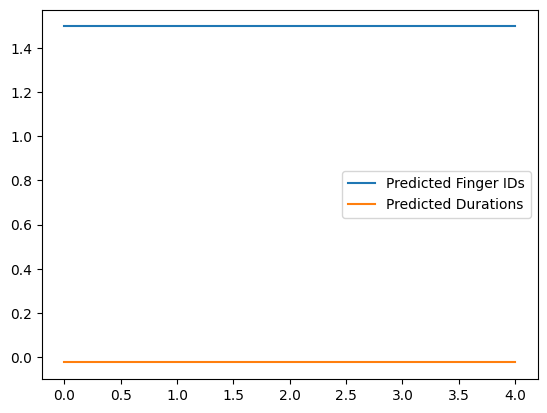

In [ ]:
import matplotlib.pyplot as plt

# ... (load your model and data)

input_sequence = [(1, 0.5), (2, 0.3), (3, 0.2)]
predicted_steps = predict_next_5_steps(input_sequence)

# Extract predicted finger IDs and durations
predicted_finger_ids = [step[0] for step in predicted_steps]
predicted_durations = [step[1] for step in predicted_steps]

# Plot the predictions
plt.plot(predicted_finger_ids, label="Predicted Finger IDs")
plt.plot(predicted_durations, label="Predicted Durations")
plt.legend()
plt.show()

label output

In [ ]:
def preprocess_input(sequence):
  """Preprocesses a raw sequence for prediction.

  Args:
    sequence: A list of (finger_id, duration) tuples representing the sequence.

  Returns:
    A padded NumPy array representing the sequence.
  """
  finger_ids = [int(pair[0]) for pair in sequence]
  durations = [pair[1] for pair in sequence]
  input_sequence = list(zip(finger_ids, durations))

  # Pad the sequence to match the model's input shape
  padded_sequence = pad_sequences([input_sequence], maxlen=max_seq_length, padding='post', dtype='float32')
  return padded_sequence

In [ ]:
# Example new input sequence
new_sequence = [(1, 0.5), (2, 0.3), (3, 0.2)]  # Replace with your actual sequence

# Preprocess the input
processed_sequence = preprocess_input(new_sequence)

In [ ]:
# Make prediction using the trained model
prediction = np.argmax(model.predict(processed_sequence), axis=1)

# Convert prediction back to label
predicted_label = label_encoder.inverse_transform(prediction)[1]

print(f"Predicted Gesture: {predicted_label}")

# label encoder

In [ ]:
import json
import numpy as np
from sklearn.preprocessing import LabelEncoder
import pickle

# 1. Load the JSON Data (Assuming your data is in 'finger_sequences.json')
with open("/content/finger_sequences.json", "r") as file:
    data = json.load(file)

# 2. Prepare Labels
labels = []
for label, instances in data.items():
    for _ in instances:  # We only need the labels, not the sequences
        labels.append(label)

# 3. Create and Fit Label Encoder
label_encoder = LabelEncoder()
label_encoder.fit(labels)

# 4. Save the Label Encoder Model
with open('label_encoder_model.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

print("Label encoder model saved to 'label_encoder_model.pkl'")

Label encoder model saved to 'label_encoder_model.pkl'
